# Logistic regression on fingerprints (ECFP4)

**Goal:** Baseline cancer vs. non-cancer classifier using 2048-bit Morgan fingerprints.

- **Data:** `ecfp_final.csv` with features `fp_0 … fp_2047` and target `Label` (0/1).
- **Method:** Class-weighted Logistic Regression with embedded `SelectFromModel` feature trimming; 5-fold stratified CV and grid search over `C`.
- **Splits:** 70% train, 10% test, 20% validation (all stratified, `random_state=42`).
- **Outputs:** Validation metrics (Accuracy, Precision, Recall, F1, ROC-AUC, PR-AUC) and confusion matrices at default (0.50), tuned-F1, screening (0.20), and recall-targeted thresholds.


## Setup

- Libraries: `scikit-learn` (modeling, CV, metrics), `pandas`/`numpy` (data), `matplotlib`/`seaborn` (plots).
- Data source: `ecfp_final.csv` on Google Drive.
- Target: `Label` (0 = non-cancer, 1 = cancer).


In [17]:
# Imports (core + modeling + metrics)
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score,
    confusion_matrix, classification_report,
    precision_recall_curve, roc_curve
)


## Load data

- Read `ecfp_final.csv`.
- Features: 2048-bit ECFP columns.
- Target: `Label` cast to integer.


In [18]:
# Drive mount (Colab): read/write dataset
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [19]:
# Load the CSV with ECFP fingerprints + Label
df = pd.read_csv('/content/drive/My Drive/ecfp_final.csv')

# Assuming your CSV has columns
X = df[[f'fp_{i}' for i in range(2048)]].values

# Labels
y = df['Label'].astype(int).values

## Data split

- **Validation**: hold out 20% to tune thresholds and report early results.  
- **Train/Test**: split the remaining 80% into 70% train and 10% test.  
- All splits are **stratified** and use `random_state=42`.

In [20]:
# Hold out 20% for validation
X_temp, X_val, y_temp, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Split remaining 80% into train and test
X_train, X_test, y_train, y_test = train_test_split(X_temp, y_temp, test_size=0.125, stratify=y_temp, random_state=42)

print("Train:", X_train.shape)
print("Test:", X_test.shape)
print("Validation:", X_val.shape)


Train: (8613, 2048)
Test: (1231, 2048)
Validation: (2462, 2048)


## Model pipeline

- **Feature selection**: `SelectFromModel(LogisticRegression)` with `threshold="median"` keeps the half of bits with larger absolute coefficients (embedded feature selection).  
- **Classifier**: `LogisticRegression(solver="liblinear", class_weight="balanced", max_iter=1000)`.  
- **Hyperparameter grid**: `clf__C ∈ {0.01, 0.1, 1, 10, 100}`.  
- **CV**: `StratifiedKFold(n_splits=5, shuffle=True, random_state=42)`.  
- **Scoring**: `f1` (more informative than accuracy under class imbalance).  
- Report best `C` and number of selected bits after refit.


In [21]:
# Define pipeline: FS + LR
pipe = Pipeline([
    ("select", SelectFromModel(LogisticRegression(max_iter=1000, class_weight='balanced', solver='liblinear'),
                               threshold='median')),
    ("clf",    LogisticRegression(max_iter=1000, class_weight='balanced', solver='liblinear'))
])

# Hyperparameter grid
param_grid = {"clf__C": [0.01, 0.1, 1, 10, 100]}

# CV setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Grid search
grid = GridSearchCV(pipe, param_grid, scoring="f1", cv=cv, n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)

best_model = grid.best_estimator_
print("Best Parameters:", grid.best_params_)

# Report selected features after final refit
n_selected = int(best_model.named_steps["select"].get_support().sum())
print("Selected features:", n_selected)

# Calculate probabilities
y_prob = best_model.predict_proba(X_val)[:, 1]
y_test_prob = best_model.predict_proba(X_test)[:, 1]

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best Parameters: {'clf__C': 0.1}
Selected features: 1024


## Validation results (default threshold 0.50)

- Predictions via for `thr=0.50`).  
- Metrics reported:
  - **Accuracy**, **Precision**, **Recall**, **F1**  
  - **ROC AUC** and **PR AUC** (threshold-free)  
- Include a **confusion matrix** heatmap with readable axis labels.


,Set,Accuracy,Precision,Recall,F1 Score,ROC AUC,PR AUC
0,Validation (thr=0.50 default),0.946385,0.162791,0.466667,0.241379,0.792121,0.188226


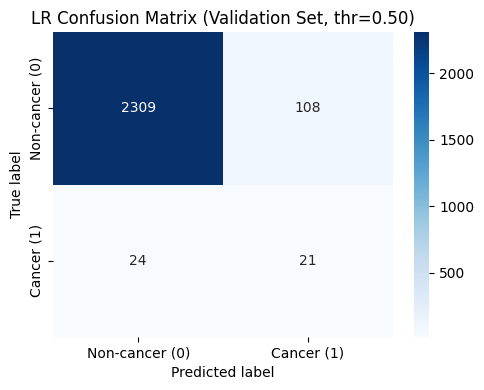

In [22]:
# Predictions (thr = 0.50)
y_pred = best_model.predict(X_val)


# Metrics table
metrics = {
    "Set":        ["Validation (thr=0.50 default)"],
    "Accuracy":   [accuracy_score(y_val, y_pred)],
    "Precision":  [precision_score(y_val, y_pred, zero_division=0)],
    "Recall":     [recall_score(y_val, y_pred)],
    "F1 Score":   [f1_score(y_val, y_pred)],
    "ROC AUC":    [roc_auc_score(y_val, y_prob)],
    "PR AUC":     [average_precision_score(y_val, y_prob)]
}
df_metrics = pd.DataFrame(metrics)
display(df_metrics)

# Confusion Matrix Heatmap
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues',
    xticklabels=["Non-cancer (0)", "Cancer (1)"],
    yticklabels=["Non-cancer (0)", "Cancer (1)"]
)
plt.title("LR Confusion Matrix (Validation Set, thr=0.50)")
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.tight_layout()
plt.show()

## Threshold tuning by F1

- Sweep candidate thresholds from unique predicted probabilities.  
- Choose the threshold that **maximizes F1** on the validation set.  
- Recompute **Accuracy**, **Precision**, **Recall**, **F1**, **ROC AUC**, **PR AUC** at the tuned threshold.  
- Show a confusion matrix at the tuned operating point.


,Set,Accuracy,Precision,Recall,F1 Score,ROC AUC,PR AUC
0,Validation (thr=tuned=0.830),0.977254,0.358974,0.311111,0.333333,0.792121,0.188226


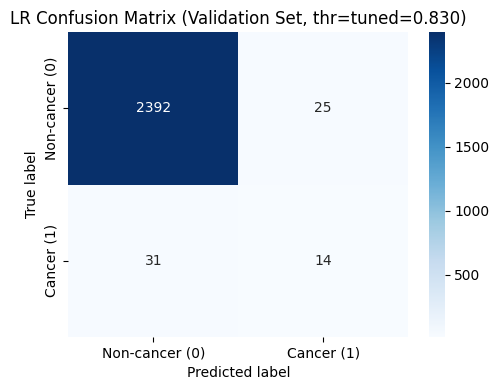

In [23]:
# Find tuned threshold on Validation by maximizing F1
candidates = np.unique(np.concatenate(([0.0], y_prob, [1.0])))
best_thr, best_f1 = 0.50, -1.0
for t in candidates:
    yhat = (y_prob >= t).astype(int)
    f1 = f1_score(y_val, yhat, zero_division=0)
    if f1 > best_f1:
        best_f1, best_thr = f1, float(t)

tuned_thr = float(best_thr)

# Evaluate at tuned threshold & present nicely
y_val_pred_tuned = (y_prob >= tuned_thr).astype(int)

metrics = {
    "Set":        [f"Validation (thr=tuned={tuned_thr:.3f})"],
    "Accuracy":   [accuracy_score(y_val, y_val_pred_tuned)],
    "Precision":  [precision_score(y_val, y_val_pred_tuned, zero_division=0)],
    "Recall":     [recall_score(y_val, y_val_pred_tuned)],
    "F1 Score":   [f1_score(y_val, y_val_pred_tuned)],
    "ROC AUC":    [roc_auc_score(y_val, y_prob)],
    "PR AUC":     [average_precision_score(y_val, y_prob)]
}
df_metrics_tuned = pd.DataFrame(metrics)
display(df_metrics_tuned)

# Confusion Matrix Heatmap (tuned threshold)
cm = confusion_matrix(y_val, y_val_pred_tuned)
plt.figure(figsize=(5,4))
sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues',
    xticklabels=["Non-cancer (0)", "Cancer (1)"],
    yticklabels=["Non-cancer (0)", "Cancer (1)"]
)
plt.title(f"LR Confusion Matrix (Validation Set, thr=tuned={tuned_thr:.3f})")
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.tight_layout()
plt.show()


## Screening scenario (fixed threshold = 0.20)

- Lowering the threshold increases recall at the cost of precision—useful for screening.  
- Evaluate the validation set at `thr = 0.20` and report the same metric table plus a confusion matrix.


,Set,Accuracy,Precision,Recall,F1 Score,ROC AUC,PR AUC
0,Validation (thr=0.20 screening),0.831844,0.06383,0.6,0.115385,0.792121,0.188226


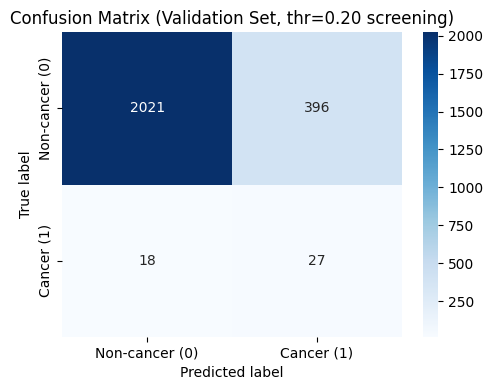

In [24]:
# Screening-focused evaluation (thr = 0.20)
threshold_screening = 0.20
y_val_preds_screening = (y_prob >= threshold_screening).astype(int)

# Metrics table
metrics_screen = {
    "Set":        [f"Validation (thr=0.20 screening)"],
    "Accuracy":   [accuracy_score(y_val, y_val_preds_screening)],
    "Precision":  [precision_score(y_val, y_val_preds_screening, zero_division=0)],
    "Recall":     [recall_score(y_val, y_val_preds_screening)],
    "F1 Score":   [f1_score(y_val, y_val_preds_screening)],
    "ROC AUC":    [roc_auc_score(y_val, y_prob)],                 # threshold-free
    "PR AUC":     [average_precision_score(y_val, y_prob)]        # threshold-free
}
df_metrics_screen = pd.DataFrame(metrics_screen)
display(df_metrics_screen)

# Confusion Matrix Heatmap
cm = confusion_matrix(y_val, y_val_preds_screening)
plt.figure(figsize=(5,4))
sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues',
    xticklabels=["Non-cancer (0)", "Cancer (1)"],
    yticklabels=["Non-cancer (0)", "Cancer (1)"]
)
plt.title("Confusion Matrix (Validation Set, thr=0.20 screening)")
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.tight_layout()
plt.show()


## Recall-targeted operating point

- Select the **smallest** threshold that achieves a target recall (e.g., `recall ≥ 0.70`), keeping precision as high as possible.  
- If the target is unattainable, fall back to `thr = 0.20`.  
- Report metrics and confusion matrix for this recall-targeted point.


,Set,Accuracy,Precision,Recall,F1 Score,ROC AUC,PR AUC
0,"Validation (recall≥0.70, thr=0.114)",0.722989,0.045649,0.711111,0.085791,0.792121,0.188226


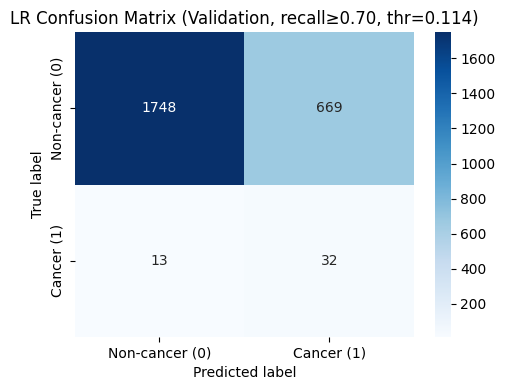

In [25]:
# Recall-targeted threshold selection
target_recall = 0.70
prec, rec, thr = precision_recall_curve(y_val, y_prob)  # thr has len = len(rec) - 1

mask = rec[:-1] >= target_recall
if mask.any():
    # Choose the largest τ that still meets the recall target (helps keep precision higher)
    idx = np.where(mask)[0][-1]
    thr_recall = float(thr[idx])
else:
    # Fallback if target recall is unattainable
    thr_recall = 0.20

# Evaluate at recall-targeted threshold
y_val_pred_recall = (y_prob >= thr_recall).astype(int)

metrics_recall = {
    "Set":        [f"Validation (recall≥{target_recall:.2f}, thr={thr_recall:.3f})"],
    "Accuracy":   [accuracy_score(y_val, y_val_pred_recall)],
    "Precision":  [precision_score(y_val, y_val_pred_recall, zero_division=0)],
    "Recall":     [recall_score(y_val, y_val_pred_recall)],
    "F1 Score":   [f1_score(y_val, y_val_pred_recall)],
    "ROC AUC":    [roc_auc_score(y_val, y_prob)],              # threshold-free
    "PR AUC":     [average_precision_score(y_val, y_prob)]     # threshold-free
}
df_metrics_recall = pd.DataFrame(metrics_recall)
display(df_metrics_recall)

# Confusion Matrix Heatmap
cm = confusion_matrix(y_val, y_val_pred_recall)
plt.figure(figsize=(5,4))
sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues',
    xticklabels=["Non-cancer (0)", "Cancer (1)"],
    yticklabels=["Non-cancer (0)", "Cancer (1)"]
)
plt.title(f"LR Confusion Matrix (Validation, recall≥{target_recall:.2f}, thr={thr_recall:.3f})")
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.tight_layout()
plt.show()


## Threshold sweep on validation — Methods

- **Procedure:** thresholds from `0.05` to `0.95` in steps of `0.05`.  
  For each `τ`, compute on the validation set:  
  `Precision(τ)`, `Recall(τ)`, and `F1(τ)` using `y_prob` and `ŷ = [p ≥ τ]`.
- **Plot:** three line series (Precision, Recall, F1) with markers.  
  Vertical reference lines mark key operating points:
  - `τ = 0.50` (default)
  - `τ = 0.20` (screening)
  - `τ = tuned_thr` (max-F1)
  - `τ = thr_recall` (recall-targeted)
- **Figure details:** title *“Precision / Recall / F1 vs Threshold • Validation”*,  
  x-axis = **Threshold**, y-axis = **Score**, legend on, grid enabled.

**Figure.** Precision (P), Recall (R), and F1 across thresholds, with dashed lines at chosen operating points.


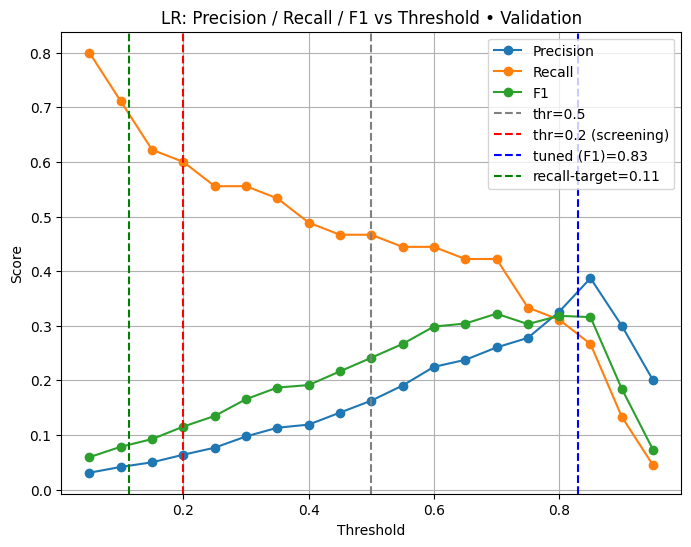

In [26]:
# Threshold sweep on validation
thresholds = np.arange(0.05, 0.96, 0.05)
precisions, recalls, f1s = [], [], []
for thr in thresholds:
    yp = (y_prob >= thr).astype(int)
    precisions.append(precision_score(y_val, yp, zero_division=0))
    recalls.append(recall_score(y_val, yp))
    f1s.append(f1_score(y_val, yp))

plt.figure(figsize=(8,6))
plt.plot(thresholds, precisions, marker='o', label='Precision')
plt.plot(thresholds, recalls,   marker='o', label='Recall')
plt.plot(thresholds, f1s,       marker='o', label='F1')

# Add vertical lines for key thresholds
plt.axvline(0.5, color='grey', linestyle='--', label='thr=0.5')
plt.axvline(0.2, color='red', linestyle='--', label='thr=0.2 (screening)')
plt.axvline(tuned_thr, color='blue', linestyle='--', label=f'tuned (F1)={tuned_thr:.2f}')
plt.axvline(thr_recall, color='green', linestyle='--', label=f'recall-target={thr_recall:.2f}')

plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('LR: Precision / Recall / F1 vs Threshold • Validation')
plt.legend()
plt.grid(True)
plt.show()


## ROC curve — Validation

- **Computation:** `fpr, tpr = roc_curve(y_val, y_prob)` with `AUC = roc_auc_score(y_val, y_prob)`.  
- **Plot:** TPR vs FPR with the diagonal `y = x` as a reference (no-skill).  
- **Reading the figure:** curves further above the diagonal indicate better ranking of positives over negatives; **AUC** summarizes this ranking independent of any threshold.

**Figure.** ROC curve on the validation set with the legend showing `AUC = …`. Axes are **False Positive Rate** (x) and **True Positive Rate** (y); grid enabled for readability.


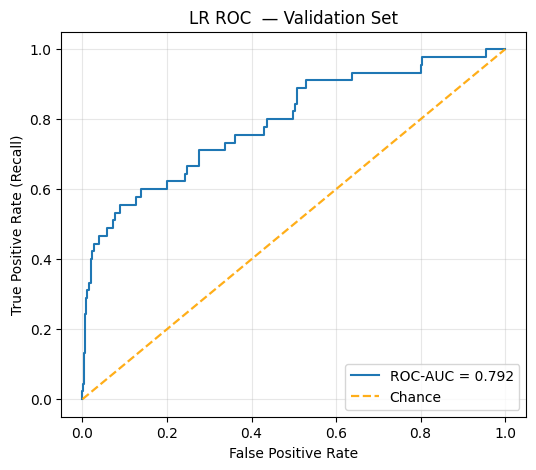

In [27]:
# ROC curve
fpr, tpr, _ = roc_curve(y_val, y_prob)
roc_auc_val = roc_auc_score(y_val, y_prob)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"ROC-AUC = {roc_auc_val:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="orange", lw=1.6, alpha=0.9, label="Chance")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("LR ROC  — Validation Set")
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

## Precision–Recall (PR) curve — Validation

- **Computation:** `precision, recall, thresholds = precision_recall_curve(y_val, y_prob)` and **Average Precision (AP)** via `average_precision_score(y_val, y_prob)`.  
- **Plot:** Precision vs Recall; AP is shown in the legend.  
- **Reading the figure:** with class imbalance, PR curves are more informative than ROC.  
  The **baseline precision** equals the positive prevalence `π = (#positives / #samples)`; curves well above this line indicate useful enrichment.

**Figure.** PR curve on the validation set with `AP = …`. Axes are **Recall** (x) and **Precision** (y); grid enabled for readability.


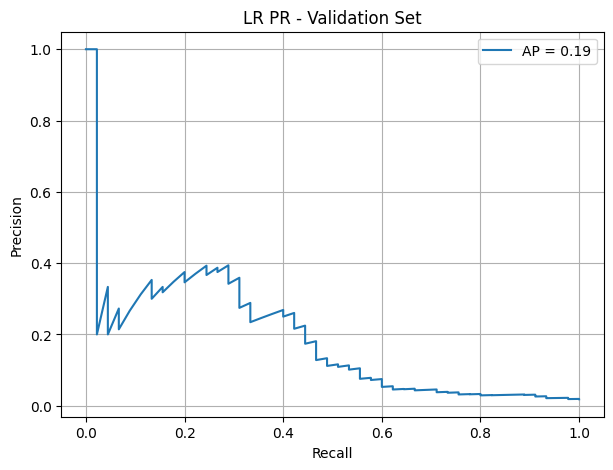

In [28]:
# PR curv
precision, recall, thresholds = precision_recall_curve(y_val, y_prob)
ap = average_precision_score(y_val, y_prob)

plt.figure(figsize=(7, 5))
plt.plot(recall, precision, label=f'AP = {ap:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('LR PR - Validation Set')
plt.legend()
plt.grid(True)
plt.show()


## Test-set evaluation

**Goal:** apply the model (fixed from training/validation) to the held-out **test set** and report performance at several operating points.

- **Thresholds evaluated:**
  - `τ = tuned_thr` (chosen on **validation** by max-F1)  
  - `τ = 0.50` (default)  
  - `τ = 0.20` (screening)  
  - `τ = thr_recall` (smallest τ that met the recall target on validation)
- **Leakage control:** thresholds are **carried over from validation**; no re-tuning on test.


TEST • Threshold-free
ROC-AUC: 0.733 | PR-AUC: 0.068


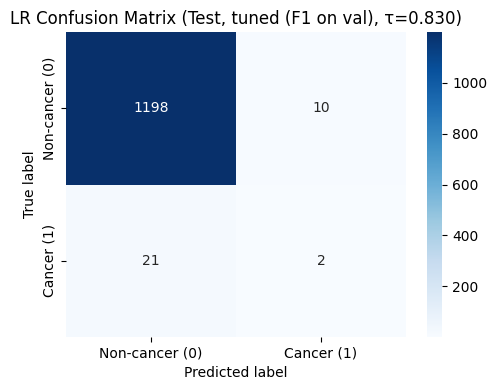

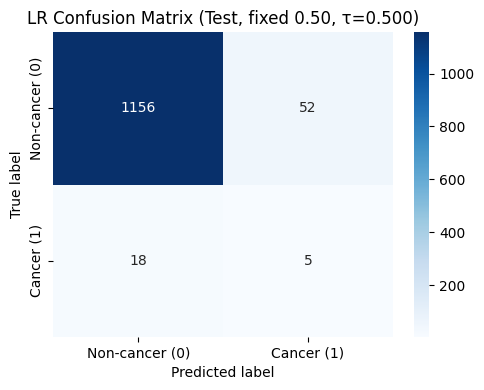

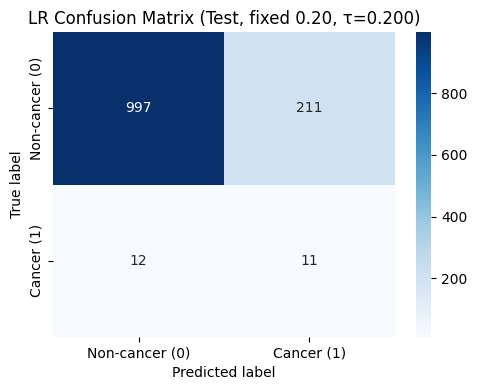

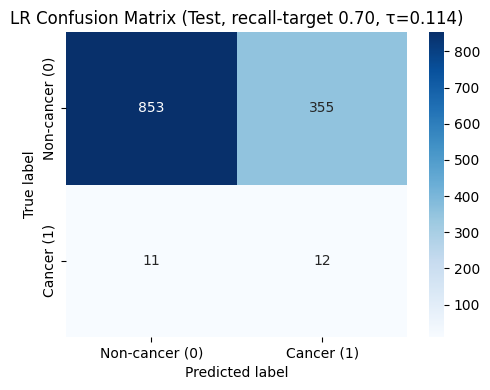

,Set,Accuracy,Precision,Recall,F1 Score,ROC AUC,PR AUC
0,"Test (tuned (F1 on val), τ=0.830)",0.974817,0.166667,0.086957,0.114286,0.732868,0.068496
1,"Test (fixed 0.50, τ=0.500)",0.943136,0.087719,0.217391,0.125000,0.732868,0.068496
2,"Test (fixed 0.20, τ=0.200)",0.818846,0.049550,0.478261,0.089796,0.732868,0.068496
3,"Test (recall-target 0.70, τ=0.114)",0.702681,0.032698,0.521739,0.061538,0.732868,0.068496


In [29]:
# Calculate probabilities for the test set
y_test_prob = best_model.predict_proba(X_test)[:, 1]

# Predictions for the test set at various thresholds
y_test_pred_tuned = (y_test_prob >= tuned_thr).astype(int)
y_test_pred_050 = (y_test_prob >= 0.50).astype(int)
y_test_pred_020 = (y_test_prob >= 0.20).astype(int)
y_test_pred_recall = (y_test_prob >= thr_recall).astype(int)

# Threshold-free metrics
roc_auc_test = roc_auc_score(y_test, y_test_prob)
pr_auc_test  = average_precision_score(y_test, y_test_prob)
print("TEST • Threshold-free")
print(f"ROC-AUC: {roc_auc_test:.3f} | PR-AUC: {pr_auc_test:.3f}")

# Helper: evaluate + plot in the same style as validation
def evaluate_and_plot_test(y_true, y_prob, y_pred, thr_value, label):
    row = {
        "Set":       f"Test ({label}, τ={thr_value:.3f})",
        "Accuracy":  accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, zero_division=0),
        "Recall":    recall_score(y_true, y_pred),
        "F1 Score":  f1_score(y_true, y_pred),
        "ROC AUC":   roc_auc_score(y_true, y_prob),           # threshold-free
        "PR AUC":    average_precision_score(y_true, y_prob)  # threshold-free
    }
    df = pd.DataFrame([row])

    # Confusion Matrix Heatmap
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(
        cm, annot=True, fmt='d', cmap='Blues',
        xticklabels=["Non-cancer (0)", "Cancer (1)"],
        yticklabels=["Non-cancer (0)", "Cancer (1)"]
    )
    plt.title(f"LR Confusion Matrix (Test, {label}, τ={thr_value:.3f})")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.tight_layout()
    plt.show()

    return df

# Metrics at each threshold (tables + heatmaps)
tables_test = []
tables_test.append(evaluate_and_plot_test(y_test, y_test_prob, y_test_pred_tuned,   tuned_thr,   "tuned (F1 on val)"))
tables_test.append(evaluate_and_plot_test(y_test, y_test_prob, y_test_pred_050,     0.50,        "fixed 0.50"))
tables_test.append(evaluate_and_plot_test(y_test, y_test_prob, y_test_pred_020,     0.20,        "fixed 0.20"))
tables_test.append(evaluate_and_plot_test(y_test, y_test_prob, y_test_pred_recall,  thr_recall,  f"recall-target {target_recall:.2f}"))

# Compact combined table for easy comparison
test_summary = pd.concat(tables_test, ignore_index=True)
display(test_summary)

## ROC curve — Test Set

- **Computation:** `fpr, tpr = roc_curve(y_test, y_test_prob)` and `AUC = roc_auc_score(y_test, y_test_prob)`.  
- **Display:** plot TPR vs FPR with the diagonal `y = x` as the no-skill reference.  
- **Interpretation:** the farther the curve bows above the diagonal, the better the ranking of positives over negatives. AUC summarizes this ranking and is **threshold-free**.

**Figure.** ROC curve on the test set with legend showing `AUC = …`. Axes: **False Positive Rate** (x) and **True Positive Rate** (y); grid enabled.


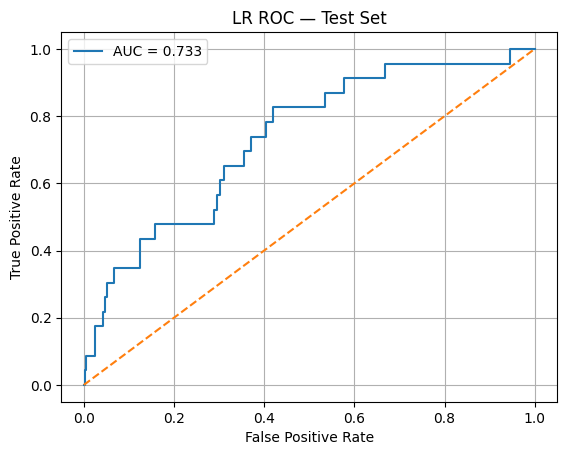

In [30]:
# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_test_prob)
plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_test:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("LR ROC — Test Set"); plt.legend(); plt.grid(True); plt.show()

## Precision–Recall (PR) curve — Test Set

- **Computation:** `precision, recall, _ = precision_recall_curve(y_test, y_test_prob)` and **Average Precision (AP)** via `average_precision_score(y_test, y_test_prob)`.  
- **Display:** Precision vs Recall with AP shown in the legend.  
- **Interpretation:** PR is more informative than ROC under class imbalance. The implicit baseline equals the positive prevalence; curves well above baseline indicate useful enrichment.

**Figure.** Precision–Recall curve on the test set with `AP = …`. Axes: **Recall** (x) and **Precision** (y); grid enabled.


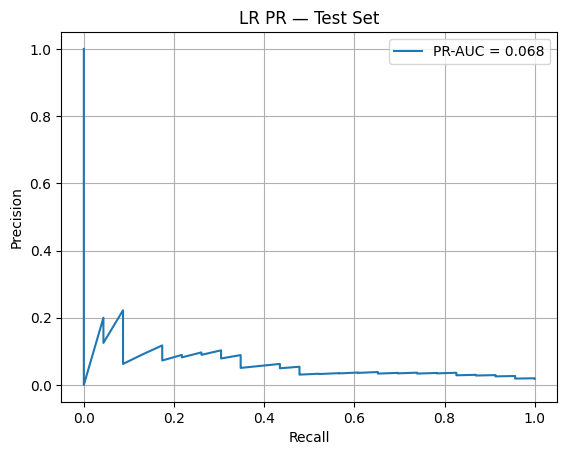

In [31]:
# PR curve
prec, rec, _ = precision_recall_curve(y_test, y_test_prob)
plt.figure()
plt.plot(rec, prec, label=f"PR-AUC = {pr_auc_test:.3f}")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("LR PR — Test Set"); plt.legend(); plt.grid(True); plt.show()
